# Detecting Deception in Enron Emails
## 1. Preprocessing Email Text and 2. Labeling Suspicious Examples

In this notebook, we import the over 500,000 Enron emails and preprocess them in order to generate proper word and paragraph vector features for clustering. We also use targeted heuristics to identify positive examples related or possibly related to fraudulent activity in order to assess the quality of clustering and topic modeling.

In [1]:
# preprocessing libraries

from __future__ import print_function
from __future__ import division

import os, sys
import collections
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import email
import nltk
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.tokenize import sent_tokenize

# Helper libraries
import constants
import utils
import vocabulary

## 1.1 Load and Separate Email Bodies
Data source from Kaggle, and basic parsing code courtesy of Zichen Wang: [Kaggle](https://www.kaggle.com/zichen/explore-enron)

In [3]:
# load csv dataset - download from Kaggle (linked above, ~.5gb)

# ENTER PATH FOR IMPORT AND EXPORT
path = 'C:/Users/Colby/Documents/Berkeley/266_NLP/final_project/data'

emails_df = pd.read_csv(path + '/emails.csv')
#TESTER
#emails_df = pd.read_csv(path + '/emails.csv', nrows = 5000)

print("Shape:", emails_df.shape)
emails_df.head()

Shape: (517401, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [4]:
# source: Zichen Wang
# isolate email body
# run-time: ~ 5 minutes on full dataset

def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

# Parse the emails into a list email objects
messages = list(map(email.message_from_string, emails_df['message']))
#emails_df.drop('message', axis=1, inplace=True)

# Parse content from emails
emails_df['content_str'] = list(map(get_text_from_email, messages))

del messages

In [10]:
# sample clean emails
sample_id = 1

emails_df.loc[sample_id, 'content_str']
print(emails_df.shape)

(517401, 3)


## 1.2 Preprocess Raw Email Contents

In [26]:
# PREPROCESSING STEP
# run-time = 30 mins on local machine with FULL dataset

tokenizer = TreebankWordTokenizer()

# preprocess email bodies with unknowns and sentence buffers
emails_preprocessed = []

for i, body in enumerate(emails_df["content_str"]):
    #get sentence level
    sents = nltk.tokenize.sent_tokenize(body.lower())
    list_sents = []
    canon = []
    for sent in sents:
        #list of tokens in sentence
        sent_tokens = tokenizer.tokenize(sent)
        new_sent = []
        for w in sent_tokens:
            re.sub("-","",w)
            if (w!="," and w!="." and "--" not in w and "@" not in w and "forwarded" not in w and "http" not in w and "www." not in w):
                new_sent += [w]
        list_sents += utils.canonicalize_words(new_sent)+["<s>"]

    emails_preprocessed.append(list_sents)

emails_df["content_proc"] = emails_preprocessed
print(emails_df.shape)
emails_df.head()

(517401, 4)


,file,message,content_str,content_proc
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast\n\n,"[here, is, our, forecast, <s>]"
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,"[traveling, to, have, a, business, meeting, ta..."
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,"[test, successful, <s>, way, to, go, !, !, <s>..."
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...","[randy, can, you, send, me, a, schedule, of, t..."
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,"[let, 's, shoot, for, tuesday, at, DGDG:DGDG, ..."


### 1.3 Limit Length of Emails

In [27]:
# final preprocessed strings for feature generation
emails_df["content_length"] = emails_df["content_proc"].apply(len)
emails_df.head()

,file,message,content_str,content_proc,content_length
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast\n\n,"[here, is, our, forecast, <s>]",5
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,"[traveling, to, have, a, business, meeting, ta...",150
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,"[test, successful, <s>, way, to, go, !, !, <s>...",11
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...","[randy, can, you, send, me, a, schedule, of, t...",39
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,"[let, 's, shoot, for, tuesday, at, DGDG:DGDG, ...",8


content_length
323047     41737
74321      42784
58523      42784
59058      44690
73895      44690
323051     44711
323616     45325
58238      45872
74539      45872
260177     47647
368235     49317
323166     50611
323180     51851
323620     53811
56264      54368
75868      54368
323068     60536
323624     69620
365604    210253
114312    247974
Name: content_length, dtype: int64


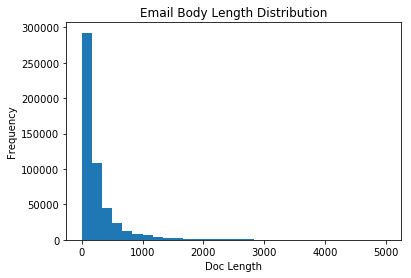

In [28]:
top_20 = np.argsort(emails_df["content_length"]).tail(20)
print(emails_df["content_length"][top_20])
plt.hist(np.array(emails_df["content_length"]), bins=30, range=(0,5000))
plt.title("Email Body Length Distribution")
plt.xlabel("Doc Length")
plt.ylabel("Frequency")
plt.show()

Very few emails have lengths of over 3,000 tokens, but some are over three orders of magnitude higher in length and should be truncated.

In [29]:
# ENTER maximum lenth informed by length distribution above
max_len = 3000

emails_df["email_list"] = emails_df["content_proc"].apply(lambda x: x[0:min(len(x), max_len)])
emails_df["email_str"] = emails_df["email_list"].apply(lambda x: ' '.join(x))
emails_df.head()

,file,message,content_str,content_proc,content_length,email_list,email_str
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast\n\n,"[here, is, our, forecast, <s>]",5,"[here, is, our, forecast, <s>]",here is our forecast <s>
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,"[traveling, to, have, a, business, meeting, ta...",150,"[traveling, to, have, a, business, meeting, ta...",traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,"[test, successful, <s>, way, to, go, !, !, <s>...",11,"[test, successful, <s>, way, to, go, !, !, <s>...",test successful <s> way to go ! ! <s> ! <s>
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...","[randy, can, you, send, me, a, schedule, of, t...",39,"[randy, can, you, send, me, a, schedule, of, t...",randy can you send me a schedule of the salary...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,"[let, 's, shoot, for, tuesday, at, DGDG:DGDG, ...",8,"[let, 's, shoot, for, tuesday, at, DGDG:DGDG, ...",let 's shoot for tuesday at DGDG:DGDG <s>


## 2. Query Raw Contents for Suspicious Phrases
### 2.1 Targeted Heuristics with Phrase Searches
Use this block to search messages strings and store the row indexes in *target_ids*
Target searches include:
- "talking point" - used to communicate with FERC (also see "spin")
- "fraud" - used surprisingly frequently
- "condor" - a specific program related to fraudulent accounting activity
- "raptor" - similar to above
- "stock price" - a frequent though typically innocuous concern
- "no recollection" and similar obfuscating phrases

In [142]:
# test phrase: enter between quotes
phrase = "stock price"

query = emails_df[emails_df['email_str'].str.contains(phrase, case=False)]
print(query.shape)
print("Matching indexes:", random.sample(query.index.tolist(), 100))

(1763, 7)
Matching indexes: [280488, 7173, 56016, 110672, 325574, 444778, 379122, 175408, 320039, 381169, 315254, 174222, 166035, 281325, 70378, 469546, 116658, 121845, 325633, 19357, 260163, 323004, 67925, 325635, 413435, 497874, 381221, 329521, 486346, 244103, 331040, 260229, 235235, 252970, 339791, 132878, 115161, 74990, 252511, 499649, 233410, 280333, 159561, 75858, 218918, 72003, 279924, 439159, 323294, 18488, 231750, 4248, 110570, 249230, 425857, 203317, 54560, 213441, 134115, 320036, 39552, 218979, 137713, 239691, 126721, 273634, 328630, 70315, 250919, 243493, 56975, 329935, 76078, 378993, 281702, 325547, 250270, 260193, 56633, 235900, 494805, 80373, 259506, 76130, 288534, 488013, 323029, 258493, 219221, 454312, 18317, 419886, 488251, 493780, 507991, 66691, 323028, 165402, 11898, 443705]


In [177]:
# ENTER matching index from list above:
enter_id = 272962
#enter_id = 272962

#use content_str for readability
print(emails_df.loc[enter_id,'content_str'])

# store ids here in the form {123: 1, 456: 1, ...}
target_dict = {16212: 1, 450200: 1, 114757: 1, 373: 1, 346: 1, 405: 1, 27091: 1, 13966: 1, 8861: 1, 92183: 1, 17932: 1, 12955: 1, 8101: 1, 19004: 1, 511116: 1,
              32643: 1, 511: 1, 908: 1, 441: 1, 931: 1, 2098: 1, 303742: 1, 272962: 1, 76036: 1, 242086: 1, 2099: 1, 153392: 1, 310898: 1, 472864: 1, 320039: 1}

There will be news on this subject soon that could  make the Rockets payments 
to the city look very paltry without some good spin.  Since you did the Enron 
Deal, I wanted to give you a heads up and some talking  points which I will 
have for you Monday. I think the news will keep until  then.


### 2.2 Review a Random Sample for Labeling

200 examples reviewed from first 50,000 emails in the dataset

In [178]:
# keep seed = 24 for sample of first 50000 emails
random.seed(24)
rand_num = 100
rand_ids_1 = random.sample(range(2000), rand_num)
rand_ids_2 = random.sample(range(2000,50000), rand_num)
rand_ids = rand_ids_1 + rand_ids_2
rand_set = emails_df.loc[rand_ids,]
print("Sample set shape:", rand_set.shape)

# For review:
#for id_ in rand_ids:
#    print(id_)
#    print(rand_set.loc[id_, 'content_str'])

# assign labels based on id
sample_dict = {373: 1, 346: 1, 405: 1, 27091: 1, 13966: 1}

Sample set shape: (200, 7)


In [181]:
# merge on labels
all_labels = sample_dict.copy()
all_labels.update(target_dict)

emails_df["suspicious_ind"] = np.zeros(emails_df.shape[0])
for k in all_labels.keys():
    emails_df.loc[k, "suspicious_ind"] = all_labels.get(k)

In [186]:
emails_df.head()

,file,message,content_str,content_proc,content_length,email_list,email_str,suspicious_ind
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast\n\n,"[here, is, our, forecast, <s>]",5,"[here, is, our, forecast, <s>]",here is our forecast <s>,0.0
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,"[traveling, to, have, a, business, meeting, ta...",150,"[traveling, to, have, a, business, meeting, ta...",traveling to have a business meeting takes the...,0.0
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,"[test, successful, <s>, way, to, go, !, !, <s>...",11,"[test, successful, <s>, way, to, go, !, !, <s>...",test successful <s> way to go ! ! <s> ! <s>,0.0
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...","[randy, can, you, send, me, a, schedule, of, t...",39,"[randy, can, you, send, me, a, schedule, of, t...",randy can you send me a schedule of the salary...,0.0
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,"[let, 's, shoot, for, tuesday, at, DGDG:DGDG, ...",8,"[let, 's, shoot, for, tuesday, at, DGDG:DGDG, ...",let 's shoot for tuesday at DGDG:DGDG <s>,0.0


## 2.3 Store Preprocessed and Labeled Dataframe

In [188]:
#to_save = emails_df.copy()
emails_df.drop(["message", "content_str", "content_proc", "content_length"], axis=1, inplace=True)

# store pickle in same location as raw email file; import in notebook #2
emails_df.to_pickle(path + '/cleaned_emails.pkl')